In [1]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

This is an example of applying :class:`~sklearn.decomposition.NMF` and
:class:`~sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a plot of topics, each represented as bar plot
using top few words based on weights.

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).


In [2]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

import pandas as pd
import pkuseg
from collections import Counter
import ast
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

In [3]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [4]:
data, TEMP = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)

In [11]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
#data为一个list，每个元素为一段字符串
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.039s.
Extracting tf-idf features for NMF...
done in 0.242s.
Extracting tf features for LDA...
done in 0.302s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.119s.


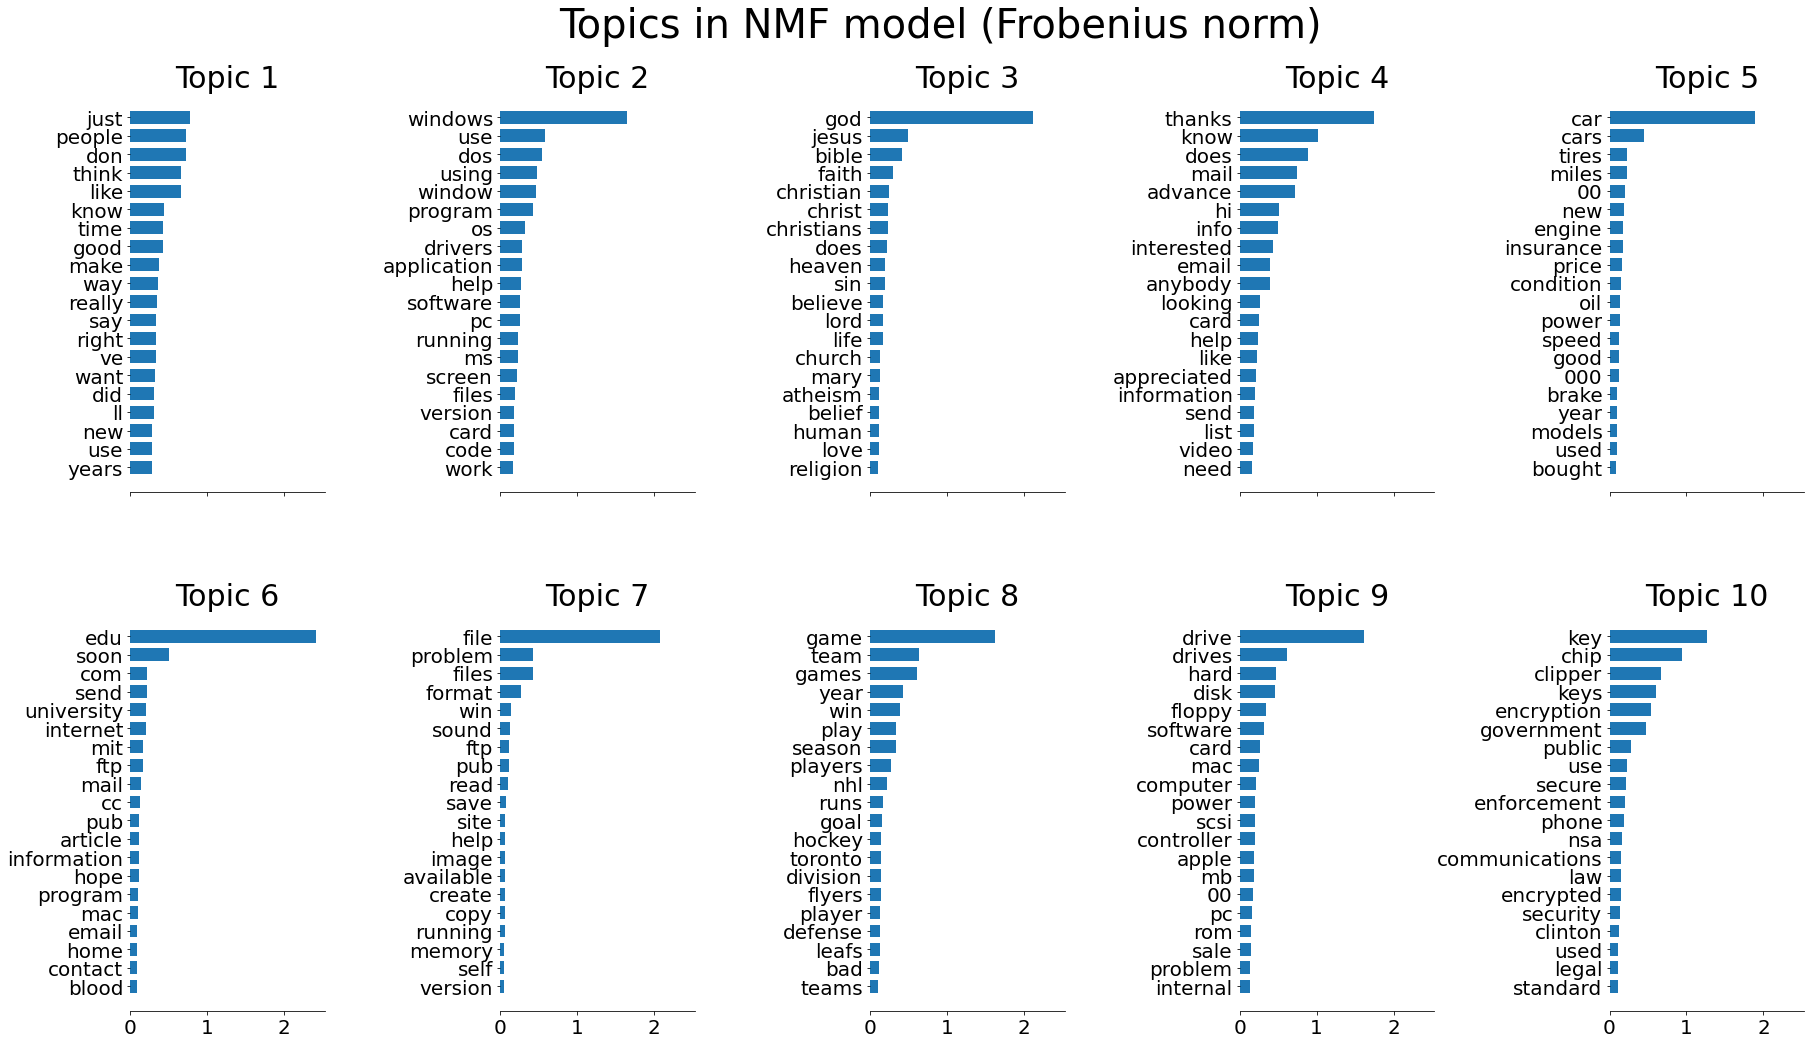



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


D:\ZZ\anaconda\envs\py36\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


done in 0.495s.


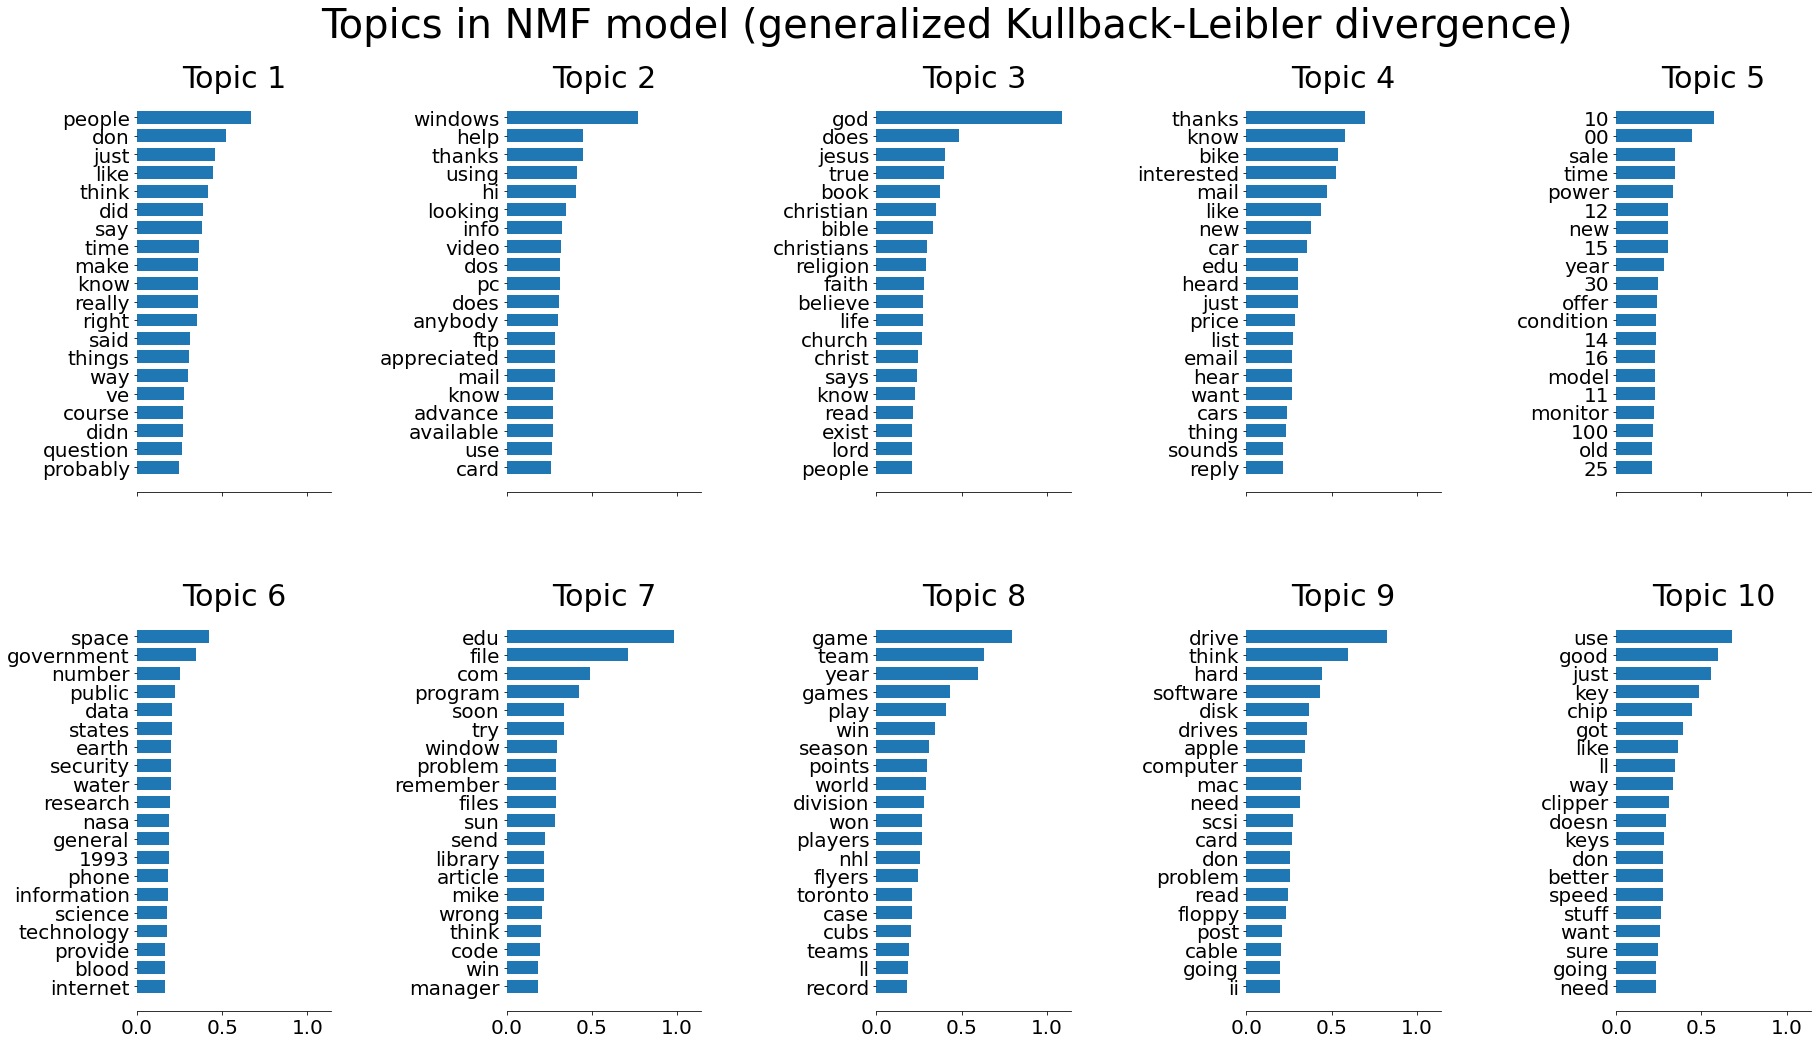



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 2.517s.


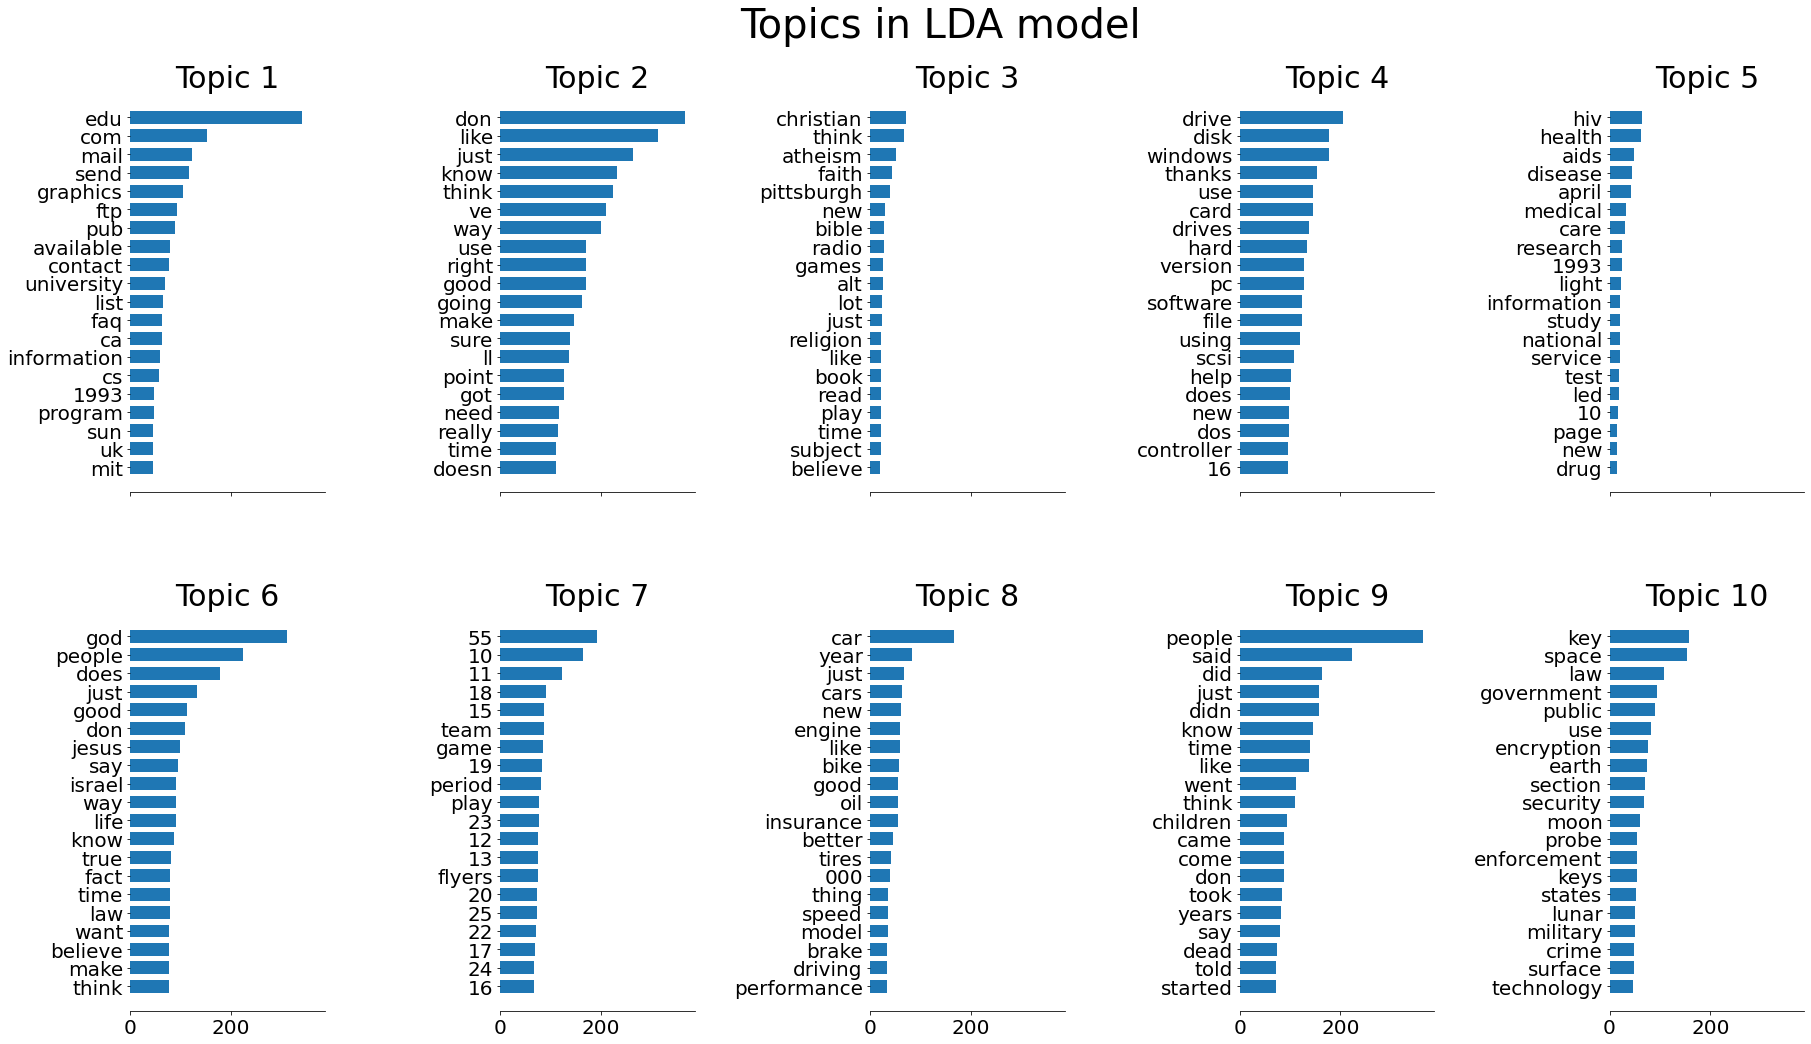

In [18]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [4]:
seg_result = sp.load_npz('seg_sparse_result.npz')#数据读入

#取
temp_word_list = pd.read_csv('seg_word_list.csv',encoding='utf-8')
word_list = temp_word_list.iloc[:,0].tolist()

    
title_word_list = [w for w in word_list if 'ttt_' in w]
note_word_list = [w for w in word_list if 'nnn_' in w]

title_seg_result = seg_result[:,0:len(title_word_list)]
note_seg_result = seg_result[:,len(title_word_list):]

In [9]:
a = []
for i in word_list:
    a.append(i[4:])

In [17]:
'上海2日自驾游'.cut

True

In [28]:
title_word_list

['ttt_06',
 'ttt_07',
 'ttt_10',
 'ttt_10年',
 'ttt_10日',
 'ttt_10月',
 'ttt_11',
 'ttt_11日',
 'ttt_11月',
 'ttt_12',
 'ttt_12日',
 'ttt_12月',
 'ttt_13',
 'ttt_14',
 'ttt_14日',
 'ttt_15',
 'ttt_15日',
 'ttt_16',
 'ttt_17',
 'ttt_17日',
 'ttt_18',
 'ttt_18年',
 'ttt_1日',
 'ttt_1月',
 'ttt_20',
 'ttt_2010年',
 'ttt_2013',
 'ttt_2013年',
 'ttt_2014',
 'ttt_2014三亚',
 'ttt_2014年',
 'ttt_2015',
 'ttt_2015年',
 'ttt_2016',
 'ttt_2016年',
 'ttt_2017',
 'ttt_2017年',
 'ttt_2018',
 'ttt_2018年',
 'ttt_2019',
 'ttt_2019年',
 'ttt_2020',
 'ttt_2020年',
 'ttt_2021年',
 'ttt_21日',
 'ttt_23',
 'ttt_2日',
 'ttt_2月',
 'ttt_3日',
 'ttt_3月',
 'ttt_4日',
 'ttt_4月',
 'ttt_5日',
 'ttt_5月',
 'ttt_6日',
 'ttt_6月',
 'ttt_7天',
 'ttt_7日',
 'ttt_7月',
 'ttt_80后',
 'ttt_8日',
 'ttt_8月',
 'ttt_90后',
 'ttt_9日',
 'ttt_9月',
 'ttt_amoy',
 'ttt_and',
 'ttt_apec',
 'ttt_baby',
 'ttt_biu',
 'ttt_city',
 'ttt_day',
 'ttt_disney',
 'ttt_get',
 'ttt_go',
 'ttt_good',
 'ttt_happy',
 'ttt_high',
 'ttt_in',
 'ttt_jia',
 'ttt_life',
 'ttt_love',
 'ttt_

In [5]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



 Fitting LDA models with tf features, n_samples=10196 and n_features=100000...
done in 477.102s.


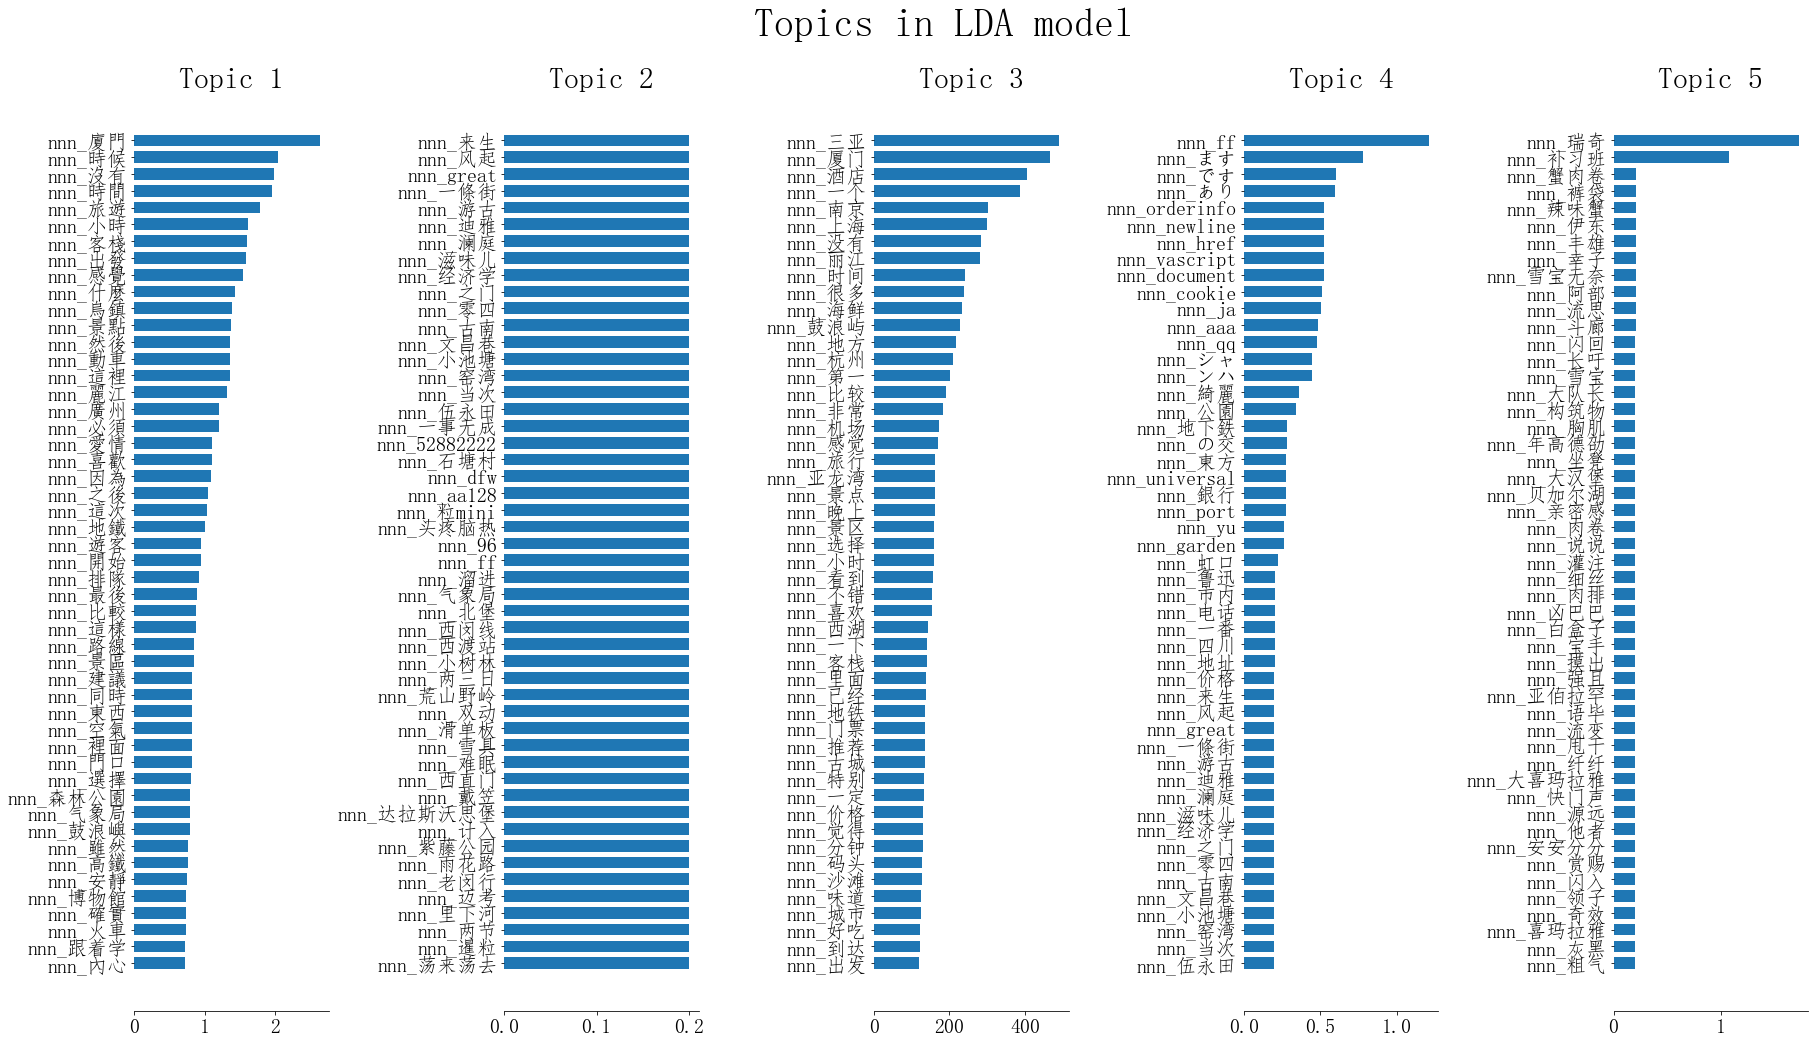

In [6]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题


n_samples = note_seg_result.shape[0]
n_features = note_seg_result.shape[1]
n_components = 3#主题数
n_top_words = 50

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=100,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(note_seg_result)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = note_word_list
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")



 Fitting LDA models with tf features, n_samples=10196 and n_features=2500...
done in 123.258s.


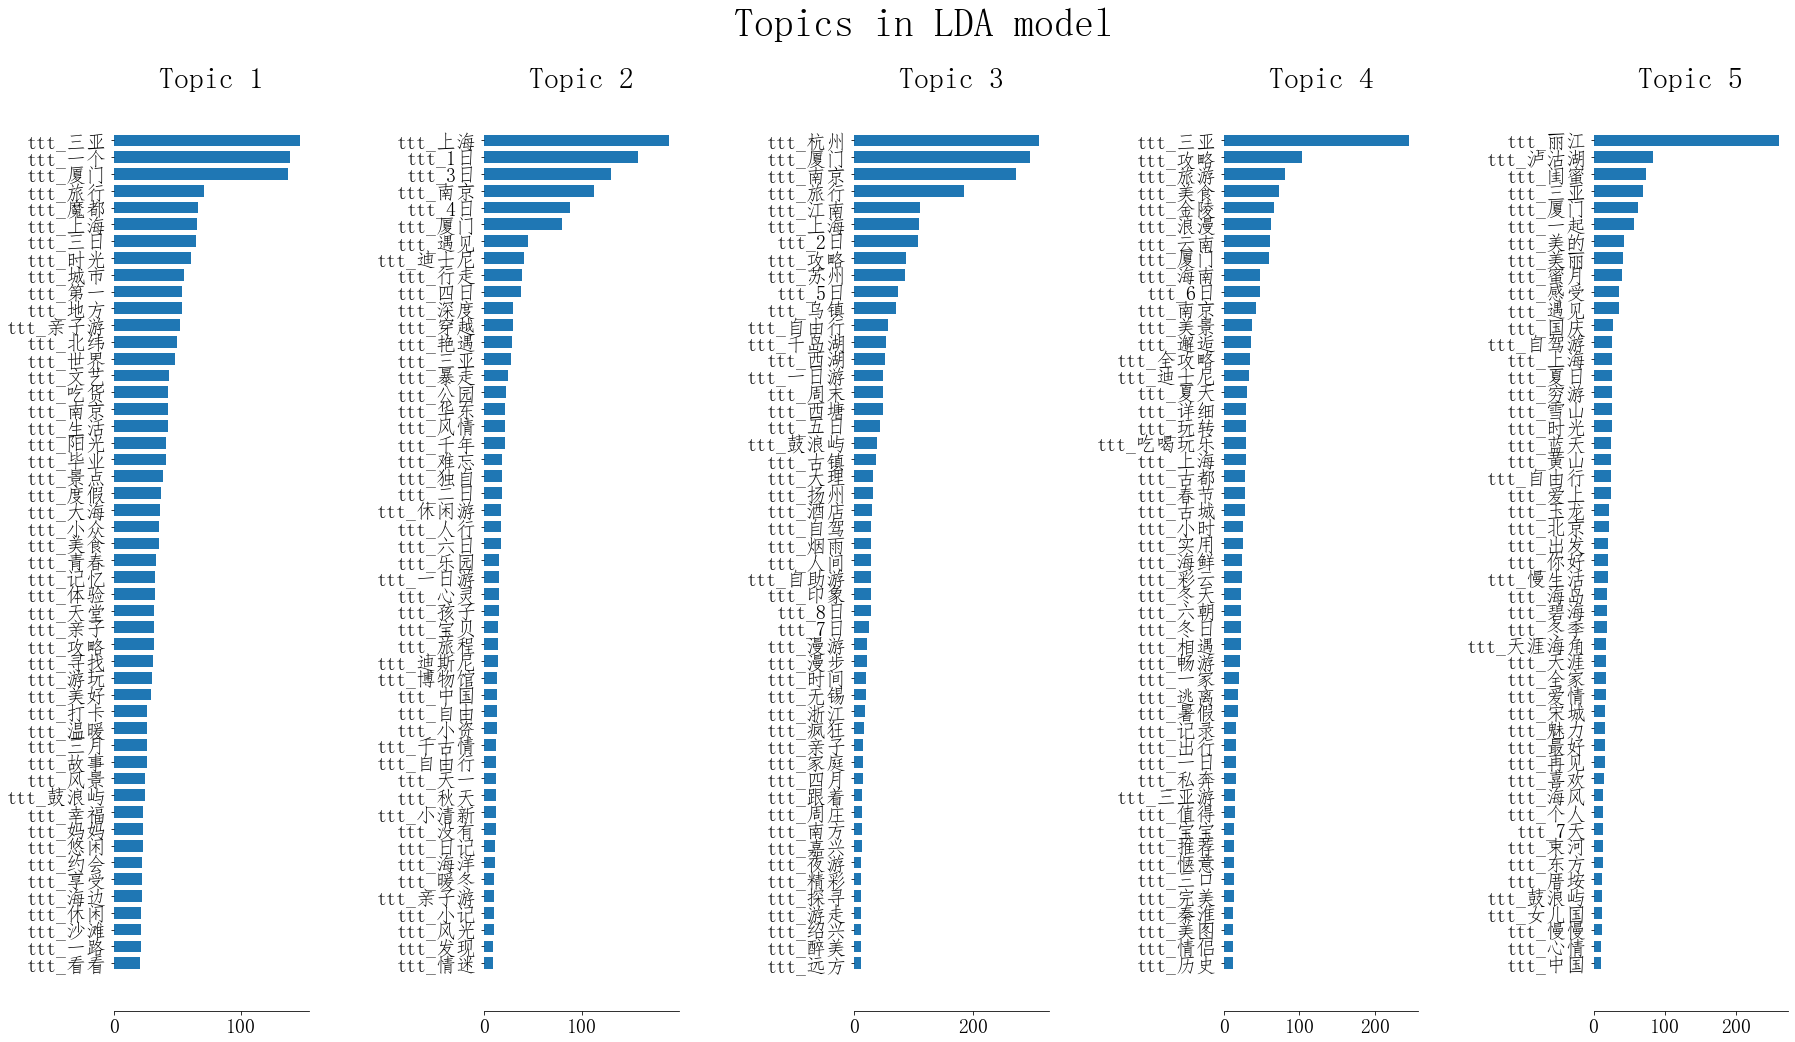

In [7]:
n_samples = title_seg_result.shape[0]
n_features = title_seg_result.shape[1]
n_components = 5#主题数
n_top_words = 50

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=100,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(title_seg_result)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = title_word_list
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

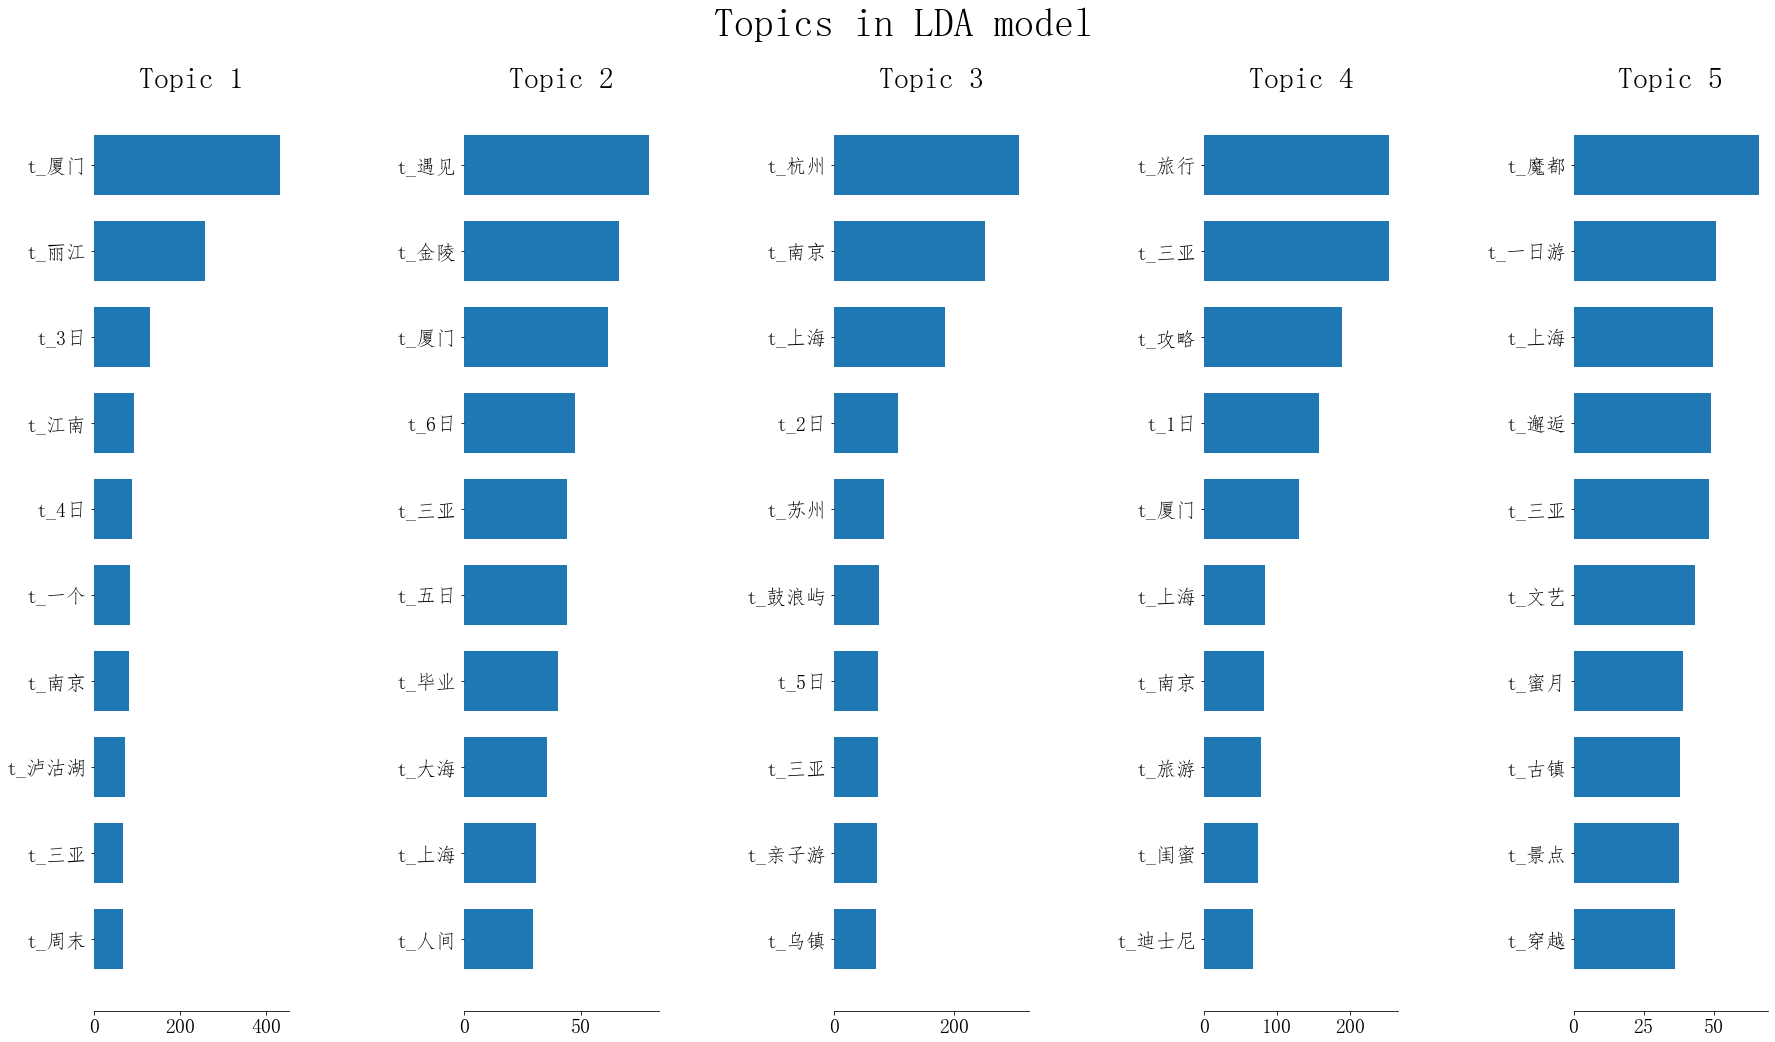

In [21]:
tf_feature_names = title_word_list
plot_top_words(lda, tf_feature_names, 10, "Topics in LDA model")